<a href="https://colab.research.google.com/github/Martinccv/Clases-DS/blob/main/Clase44_Active_Learning_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning

# Librerias

Comenzaremos cargando las librerias que usaremos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

from sklearn.datasets import make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, log_loss

# Generación del DataFrame de Juguete

Vamos a comenzar trabajando con un dataset sintético.

La siguiente celda simplemente arma el dataset sintético.

In [2]:
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=0.7, n_features=2, random_state=0)
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

In [3]:
X.shape

(1000, 2)

In [4]:
y.shape

(1000,)

La idea es permanecer agnostico a las etiquetas. Este sería el caso de como nos llegan los datos.

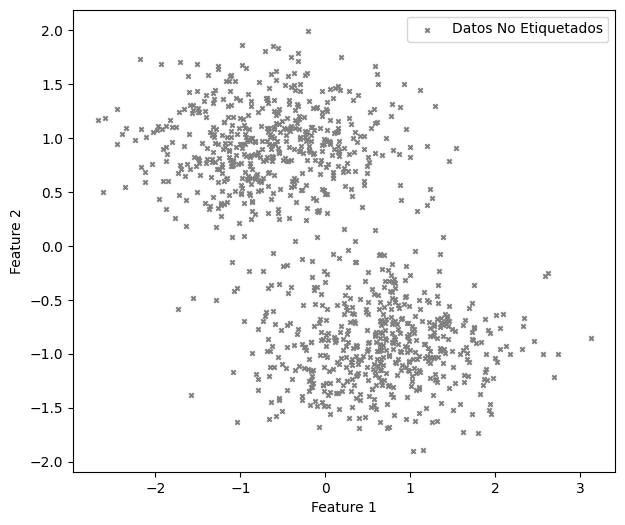

In [5]:
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c='grey', s=10, marker='x', label='Datos No Etiquetados')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Sin embargo, para esta notebook conocemos todas las etiquetas de antemano:

<ipython-input-6-b21e3c714a88>:2: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[:, 0], X[:, 1], c=['red' if label == 0 else 'green' for label in y], cmap=plt.cm.Paired, s=10, edgecolors='k', marker='x', label='Etiquetas Reales')
<ipython-input-6-b21e3c714a88>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=['red' if label == 0 else 'green' for label in y], cmap=plt.cm.Paired, s=10, edgecolors='k', marker='x', label='Etiquetas Reales')


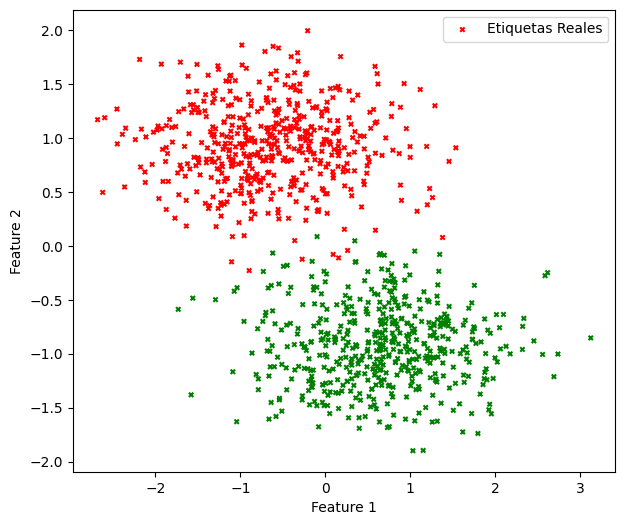

In [6]:
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=['red' if label == 0 else 'green' for label in y], cmap=plt.cm.Paired, s=10, edgecolors='k', marker='x', label='Etiquetas Reales')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


Estas etiquetas las utilizaremos cuando el *Oraculo* necesite etiquetar manualmente.

# DataFrame no etiquetado vs. DataFrame etiquetado

Vamos a tomar apenas 3 datos del dataframe original como el conjunto de datos etiquetados inicial (X_lab, y_lab). El resto van a ser todos los datos no etiquetados.

In [7]:
X_lab = X[997:]
y_lab = y[997:]
X_unlab = X[:997]
y_unlab = y[:997]

Los graficamos.

<ipython-input-8-549a7ad95651>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Etiquetas Iniciales')


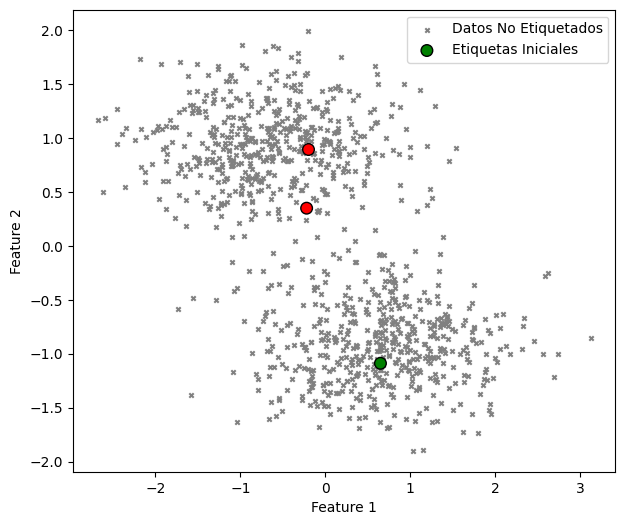

In [8]:
plt.figure(figsize=(7, 6))
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c='grey', s=10, marker='x', label='Datos No Etiquetados')
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Etiquetas Iniciales')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Entrenamos un modelo ML simple

In [9]:
# Entrenar un clasificador SVM con un kernel lineal
clf = LinearSVC(C = 1, random_state = 0)
clf.fit(X_lab, y_lab)

# Predicciones en el conjunto de prueba
y_pred = clf.predict(X_unlab)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Vemos las predicciones que me genera en el conjunto no etiquetado

<ipython-input-10-cbdb42284d12>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Etiquetas Iniciales')


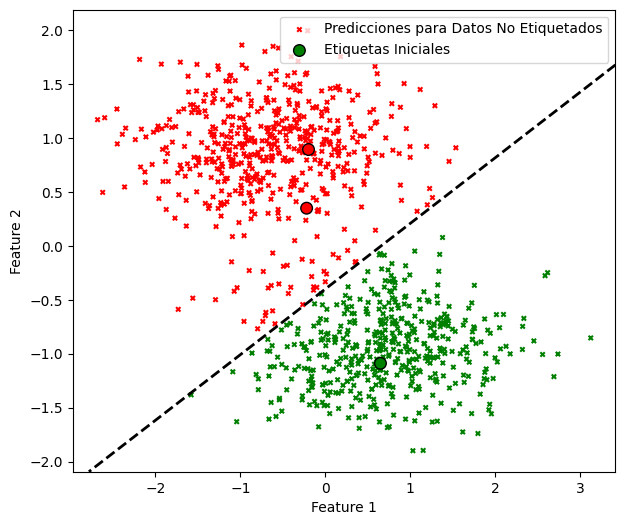

In [10]:
plt.figure(figsize=(7, 6))

plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=['red' if label == 0 else 'green' for label in y_pred], s=10, marker='x', label='Predicciones para Datos No Etiquetados')
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Etiquetas Iniciales')

# Graficar la recta de decisión
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Graficar la recta de decisión
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)

# Añadir leyenda y etiquetas
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Mostrar el gráfico
plt.show()

Como en este caso super particular conozco las etiquetas reales (no ocurre en la vida real), podemos ir chequeando alguna métrica que me diga como evoluciona el modelito simple con cada iteración.

In [11]:
metrica = []

In [12]:
accuracy = accuracy_score(y_unlab, y_pred)
metrica.append(accuracy)
print(metrica)

[0.9648946840521565]


Uso la frontera de decisión del clasificador para etiquetar los datos mas próximos más algunos datos aleatorios.

In [13]:
num_samples_to_label = 5  # Número de muestras a etiquetar por el oraculo
num_samples_to_label_uncertain = 5  # Número de ejemplos más cercanos a la frontera para etiquetar manualmente
num_samples_to_label_random = num_samples_to_label - num_samples_to_label_uncertain  # Número de muestras aleatorias a etiquetar por el oraculo

# Calcular la distancia a la frontera de decisión
distances_to_decision_boundary = np.abs(clf.decision_function(X_unlab))

# Seleccionar los ejemplos más cercanos a la frontera para etiquetar manualmente
selected_samples_closest_indices = np.argsort(distances_to_decision_boundary)[:num_samples_to_label_uncertain]

# Seleccionar algunas muestras aleatorias
selected_samples_random_indices = random.sample(range(len(X_unlab)), num_samples_to_label_random)

# Combinar las muestras cercanas a la frontera con las muestras aleatorias
selected_samples_indices = np.concatenate([selected_samples_closest_indices, selected_samples_random_indices])
selected_samples_indices = selected_samples_indices.astype(int)

selected_samples = []
selected_labels = []
for idx in selected_samples_indices:
    selected_samples.append(X_unlab[idx, :])
    selected_labels.append(y_unlab[idx])

# Anexar las muestras seleccionadas a X_lab
X_lab_2 = np.vstack([X_lab, selected_samples])
y_lab_2 = np.hstack([y_lab, selected_labels])

Este subconjunto de datos le lleva a la bolsa de datos etiquetados y se los borra del conjunto de datos no etiquetados

In [14]:
# Indices de las muestras seleccionadas que serán eliminadas de X_unlab e y_unlab
indices_to_remove = np.array(selected_samples_indices)

# Eliminar las muestras de X_unlab
X_unlab_2 = np.delete(X_unlab, indices_to_remove, axis=0)

# Eliminar las etiquetas correspondientes de y_unlab
y_unlab_2 = np.delete(y_unlab, indices_to_remove)
y_pred_2 = np.delete(y_pred, indices_to_remove)

Con el nuevo conjunto de datos etiquetados y sus etiquetas (X_lab2, y_lab2) volvemos a generar un nuevo modelos de ML simple.

In [15]:
clf_2 = LinearSVC(C = 1, random_state = 0)
clf_2.fit(X_lab_2, y_lab_2)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1, random_state=0)

Graficamos todo el proceso hasta aqui:

<ipython-input-16-a63ae6161674>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Datos etiquetados - DE')
<ipython-input-16-a63ae6161674>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
<ipython-input-16-a63ae6161674>:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
<ipython-input-16-a63ae6161674>:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lab_2[:,

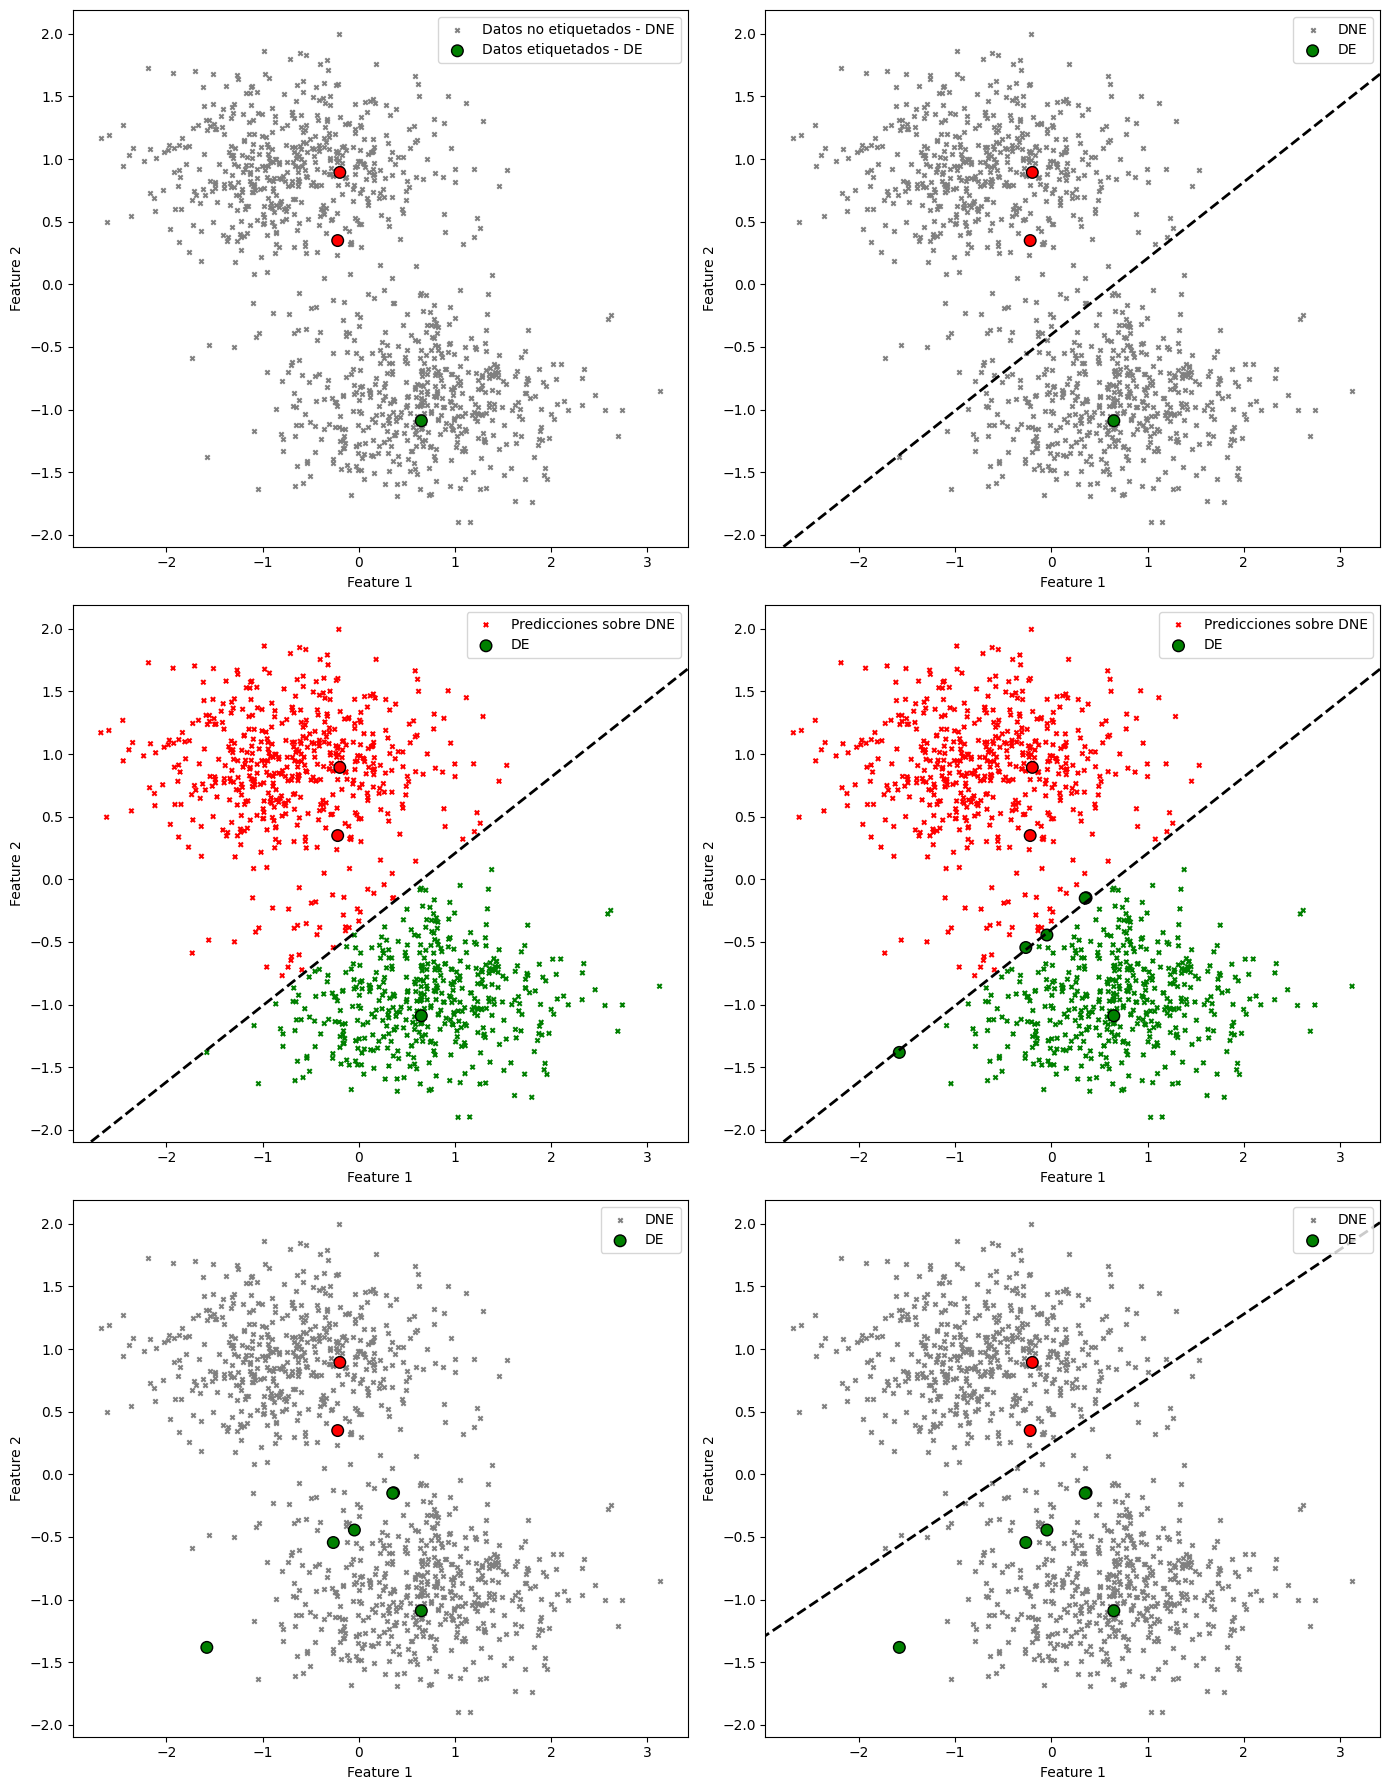

In [16]:
plt.figure(figsize=(14, 18))


# Primer gráfico
plt.subplot(3, 2, 1)
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c='grey', s=10, marker='x', label='Datos no etiquetados - DNE')
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='Datos etiquetados - DE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Segundo gráfico
plt.subplot(3, 2, 2)
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c='grey', s=10, marker='x', label='DNE')
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Tercer gráfico
plt.subplot(3, 2, 3)
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=['red' if label == 0 else 'green' for label in y_pred], s=10, marker='x', label='Predicciones sobre DNE')
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=['red' if label == 0 else 'green' for label in y_lab], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Cuarto gráfico
plt.subplot(3, 2, 4)
plt.scatter(X_unlab_2[:, 0], X_unlab_2[:, 1], c=['red' if label == 0 else 'green' for label in y_pred_2], s=10, marker='x', label='Predicciones sobre DNE')
plt.scatter(X_lab_2[:, 0], X_lab_2[:, 1], c=['red' if label == 0 else 'green' for label in y_lab_2], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Quinto gráfico
plt.subplot(3, 2, 5)
plt.scatter(X_unlab_2[:, 0], X_unlab_2[:, 1], c='grey', s=10, marker='x', label='DNE')
plt.scatter(X_lab_2[:, 0], X_lab_2[:, 1], c=['red' if label == 0 else 'green' for label in y_lab_2], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()


# Sexto gráfico
plt.subplot(3, 2, 6)
plt.scatter(X_unlab_2[:, 0], X_unlab_2[:, 1], c='grey', s=10, marker='x', label='DNE')
plt.scatter(X_lab_2[:, 0], X_lab_2[:, 1], c=['red' if label == 0 else 'green' for label in y_lab_2], cmap=plt.cm.Paired, s=70, edgecolors='k', label='DE')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
Z = clf_2.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [17]:
# Predicciones en el conjunto de prueba
y_pred_2 = clf.predict(X_unlab_2)

accuracy = accuracy_score(y_unlab_2, y_pred_2)
metrica.append(accuracy)
print(metrica)

[0.9648946840521565, 0.967741935483871]


A partir de aqui deberíamos continuar con el Loop como hasta ahora, solo que:

X_lab_k ===>  X_lab_k+1

y_lab_k ===>  y_lab_k+1

X_unlab_k ===>  X_unlab_k+1

y_unlab_k ===>  y_unlab_k+1

clf_k ===>  clf_k+1

# EJERCICIO

Implementar un loop de Active Learning

Iteración 1:
Score del modelo en iteración 1: 0.9788306451612904


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


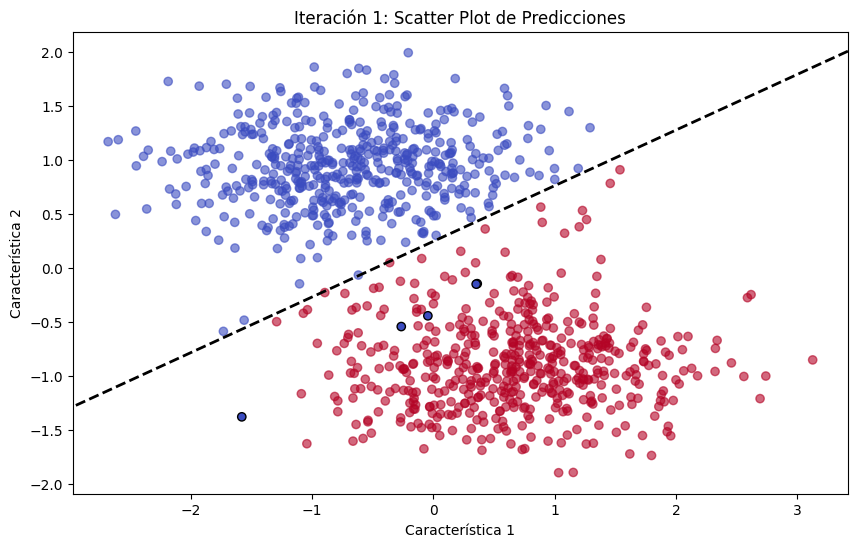

Iteración 2:
Score del modelo en iteración 2: 0.9868287740628167


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


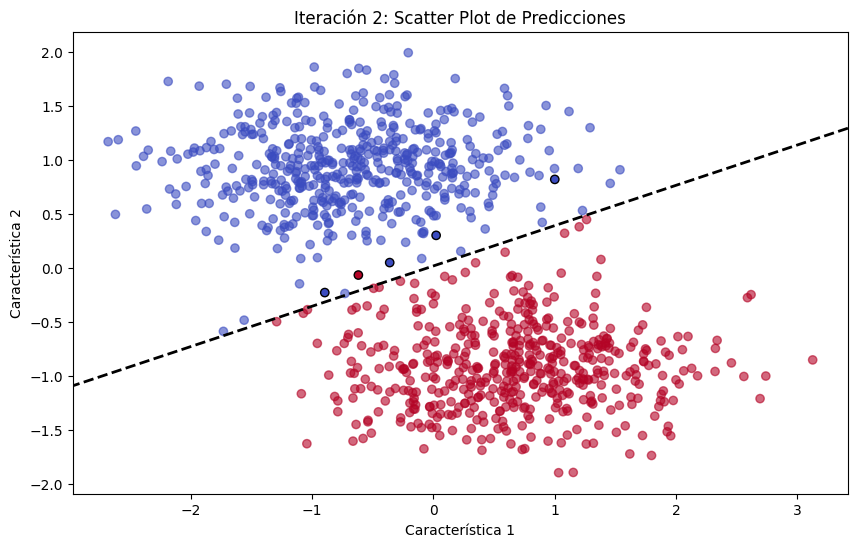

Iteración 3:
Score del modelo en iteración 3: 0.9928716904276986


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


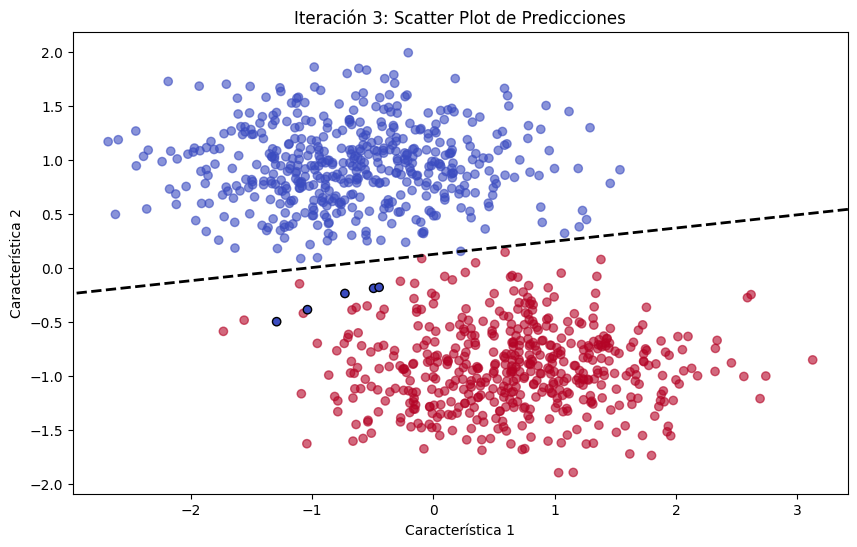

Iteración 4:
Score del modelo en iteración 4: 0.9938587512794268


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


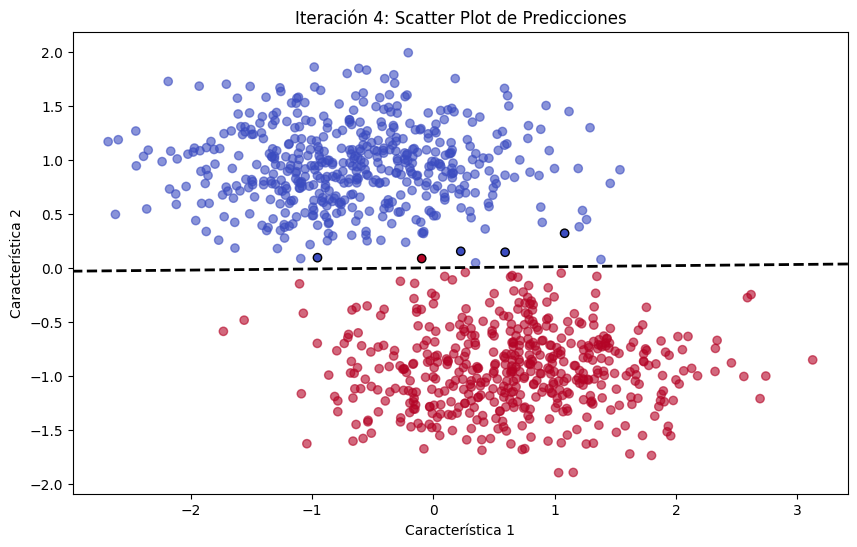

Iteración 5:
Score del modelo en iteración 5: 0.9958847736625515


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


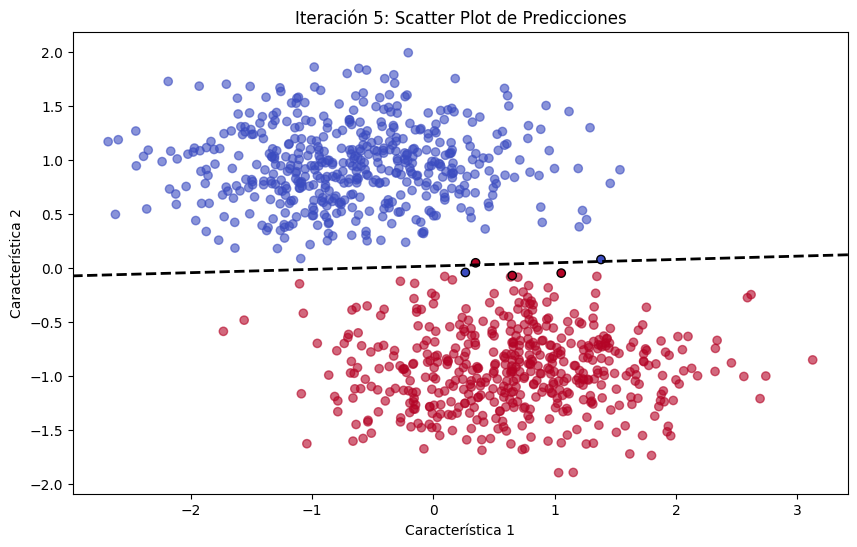

Iteración 6:
Score del modelo en iteración 6: 0.9979317476732161


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


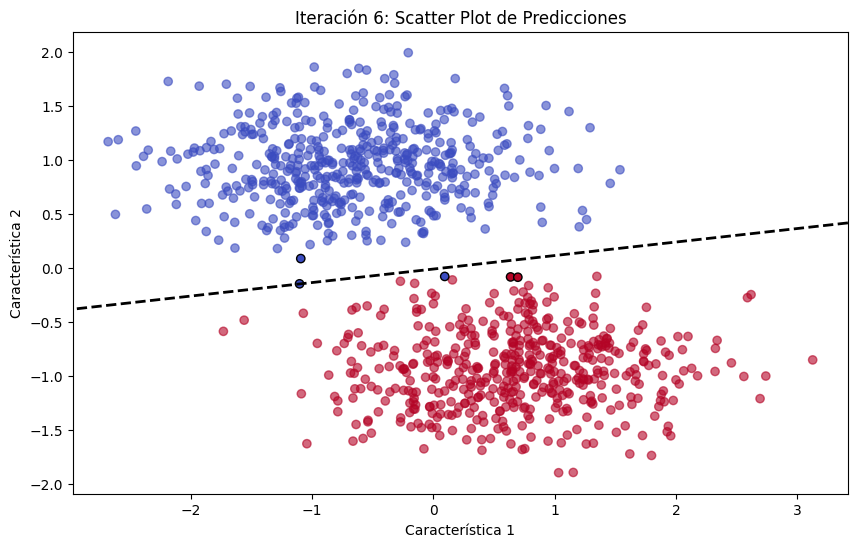

Iteración 7:
Score del modelo en iteración 7: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


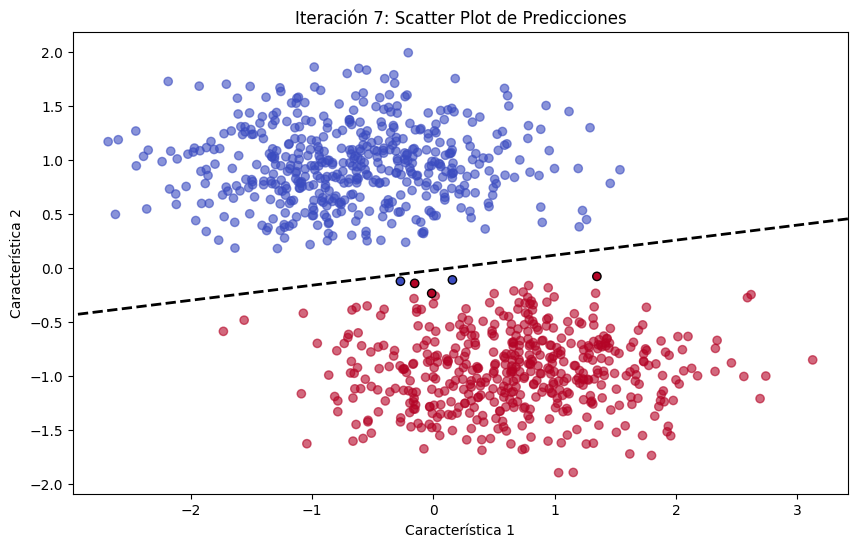

Iteración 8:
Score del modelo en iteración 8: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


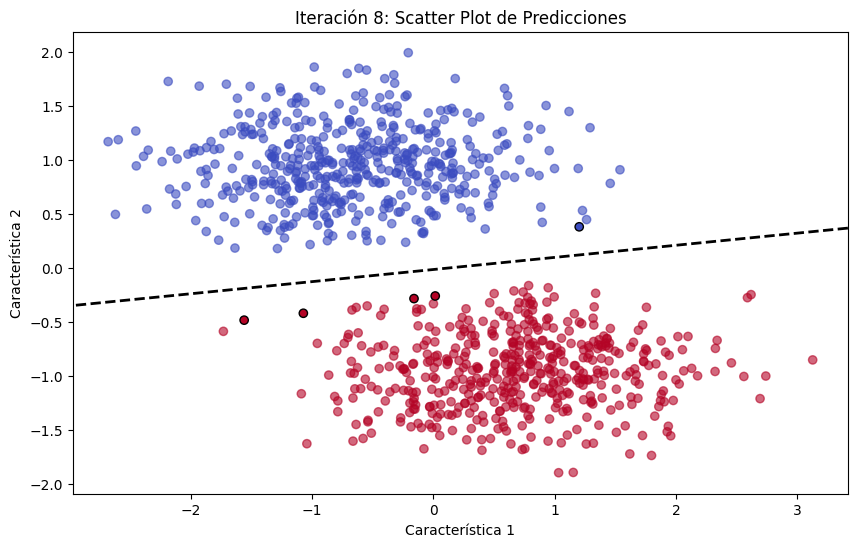

Iteración 9:
Score del modelo en iteración 9: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


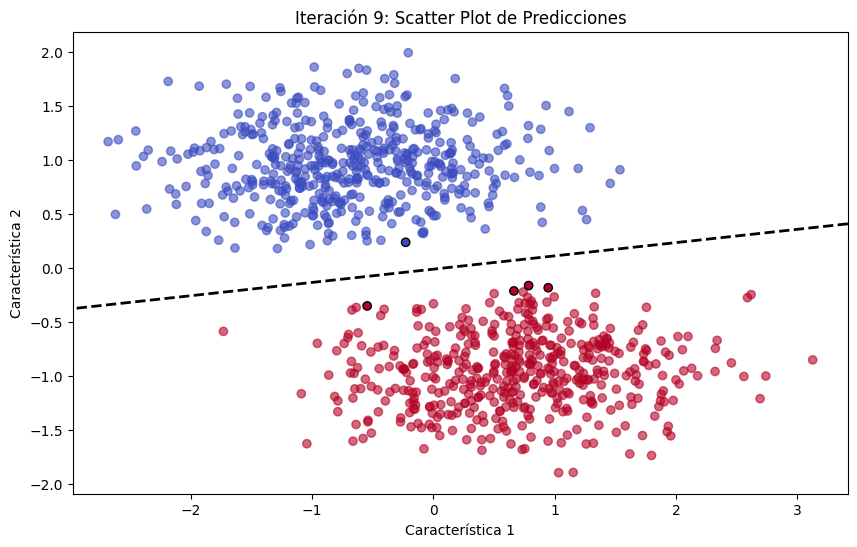

Iteración 10:
Score del modelo en iteración 10: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


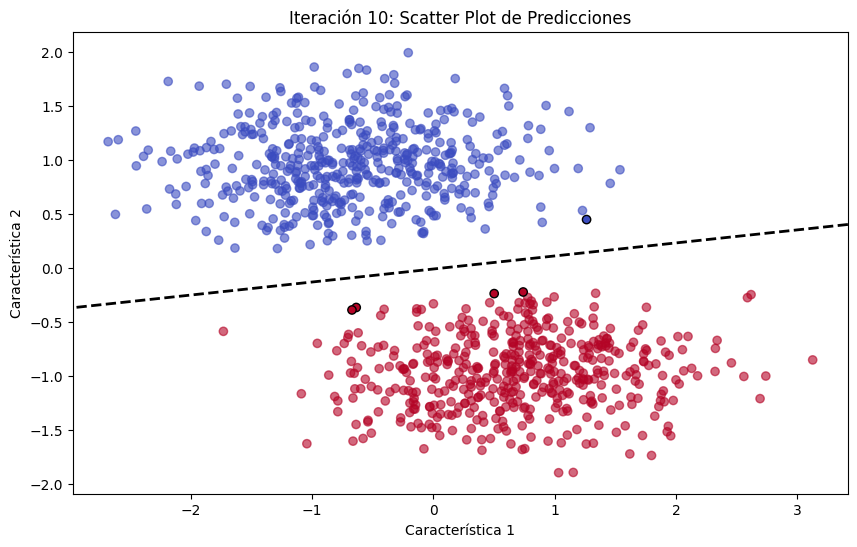


Resultados después de todas las iteraciones:
Iteración 1: Score = 0.9788306451612904
metrica:[0.9648946840521565, 0.967741935483871, 1.0]
Iteración 2: Score = 0.9868287740628167
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0]
Iteración 3: Score = 0.9928716904276986
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0]
Iteración 4: Score = 0.9938587512794268
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0]
Iteración 5: Score = 0.9958847736625515
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0]
Iteración 6: Score = 0.9979317476732161
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iteración 7: Score = 1.0
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iteración 8: Score = 1.0
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Iteración 9: Score = 1.0
metrica:[0.9648946840521565, 0.967741935483871, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [18]:
# Definir el número de iteraciones para realizar el loop
num_iterations = 10  # Cambia este valor según la cantidad de iteraciones deseada

# Asumimos que clf es el modelo inicialmente entrenado y X_lab, y_lab, X_unlab, y_unlab están ya definidos
results = []
for i in range(num_iterations):
    print(f"Iteración {i + 1}:")

    # Calcular la distancia a la frontera de decisión
    distances_to_decision_boundary = np.abs(clf.decision_function(X_unlab))

    # Seleccionar los ejemplos más cercanos a la frontera para etiquetar manualmente
    selected_samples_closest_indices = np.argsort(distances_to_decision_boundary)[:num_samples_to_label_uncertain]

    # Seleccionar algunas muestras aleatorias
    selected_samples_random_indices = random.sample(range(len(X_unlab)), num_samples_to_label_random)

    # Combinar las muestras cercanas a la frontera con las muestras aleatorias
    selected_samples_indices = np.concatenate([selected_samples_closest_indices, selected_samples_random_indices])
    selected_samples_indices = selected_samples_indices.astype(int)

    # Crear arrays para las muestras seleccionadas y sus etiquetas
    selected_samples = X_unlab[selected_samples_indices]
    selected_labels = y_unlab[selected_samples_indices]

    # Anexar las muestras seleccionadas a los datos etiquetados
    X_lab = np.vstack([X_lab, selected_samples])
    y_lab = np.hstack([y_lab, selected_labels])

    # Eliminar las muestras seleccionadas de los datos no etiquetados
    X_unlab = np.delete(X_unlab, selected_samples_indices, axis=0)
    y_unlab = np.delete(y_unlab, selected_samples_indices)

    # Reentrenar el modelo con los datos actualizados
    clf.fit(X_lab, y_lab)

    # Evaluar el modelo en los datos no etiquetados restantes (opcional)
    score = clf.score(X_unlab, y_unlab)
    print(f"Score del modelo en iteración {i + 1}: {score}")

    # Guardar el score para análisis posterior
    results.append(score)

    # Visualizar la predicción con un scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=clf.predict(X_unlab), cmap='coolwarm', alpha=0.6)
    plt.scatter(selected_samples[:, 0], selected_samples[:, 1], c=selected_labels, cmap='coolwarm', edgecolor='k')
    plt.title(f'Iteración {i + 1}: Scatter Plot de Predicciones')
    plt.xlabel('Característica 1')
    plt.ylabel('Característica 2')
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[0], linestyles=['--'], linewidths=2)
    plt.show()

# Resultados después de todas las iteraciones
print("\nResultados después de todas las iteraciones:")
for i, score in enumerate(results):
    print(f"Iteración {i + 1}: Score = {score}")
    y_pred = clf.predict(X_unlab)
    accuracy = accuracy_score(y_unlab, y_pred)
    metrica.append(accuracy)
    print(f"metrica:{metrica}")
